In [ ]:
#Remove incomplete years
#Convert dates into something useful
#Plot number of heating complaints over time
#Work that into an equation.
#Tune the equation to be more accurate...
    #Test each year against all the other years.  What was that technical term again?
    #Quantitatively measure the test vs. train accuracy as the model gets better fit but before over-fitting it.

#### <h1 style="text-align:center">Data Science and Machine Learning Capstone Project</h1>
<img style="float:right" src="https://prod-edxapp.edx-cdn.org/static/edx.org/images/logo.790c9a5340cb.png">
<p style="text-align:center">IBM: DS0720EN</p>
<p style="text-align:center">Question 4 of 4</p>

1. [Problem Statement](#problem)
2. [Question 4](#question)
3. [Data Cleaning and Standardization](#wrangling)
4. [Analyzing and Visualizing](#analysis)
5. [Concluding Remarks](#conclusion)

<a id="problem"></a>
# Problem Statement
---

The people of New York use the 311 system to report complaints about the non-emergency problems to local authorities. Various agencies in New York are assigned these problems. The Department of Housing Preservation and Development of New York City is the agency that processes 311 complaints that are related to housing and buildings.

In the last few years, the number of 311 complaints coming to the Department of Housing Preservation and Development has increased significantly. Although these complaints are not necessarily urgent, the large volume of complaints and the sudden increase is impacting the overall efficiency of operations of the agency.

Therefore, the Department of Housing Preservation and Development has approached your organization to help them manage the large volume of 311 complaints they are receiving every year.

The agency needs answers to several questions. The answers to those questions must be supported by data and analytics. These are their  questions:

<a id="question"></a>
# Question 4
---

Can a predictive model be built for future prediction of the possibility of complaints of the specific type that you identified in response to Question 1?

## Approach
Attempt to build a predictive model to predict heating complaints by using past data.

## Load Data
Separately from this notebook:

The [New York 311](https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9) data was loaded by [SODA](https://data.cityofnewyork.us/resource/fhrw-4uyv.csv?$limit=100000000&Agency=HPD&$select=created_date,unique_key,complaint_type,incident_zip,incident_address,street_name,address_type,city,resolution_description,borough,latitude,longitude,closed_date,location_type,status) into a Pandas DataFrame then saved to a pickle file.

The [New York PLUTO](https://data.cityofnewyork.us/City-Government/Primary-Land-Use-Tax-Lot-Output-PLUTO-/xuk2-nczf) data was downloaded.

<p style="color:Red;">The instructions at ( Course / 1. Project Challenge Details and Setup / Datasets Used in this Course / Datasets ) said "Use only the part that is specific to the borough that you are interested in based on your analysis."  My answer for Question 2 suggested the borough with the biggest HEAT/HOT WATER problem was BRONX.  For that reason, only the BX_18v1.csv file was loaded into a Pandas DataFrame then saved to a pickle file. The 311 data is filtered by borough after borough standardization later in the notebook.</p>

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from math import sqrt

files_path = 'C:\\Users\\It_Co\\Documents\\DataScience\\Capstone\\' #local
#files_path = './' #IBM Cloud / Watson Studio

In [2]:
b311 = pd.read_pickle(files_path + 'ny311full.pkl')

#file_columns = ['Address','BldgArea','BldgDepth','BuiltFAR','CommFAR','FacilFAR','Lot','LotArea','LotDepth','NumBldgs','NumFloors','OfficeArea','ResArea','ResidFAR','RetailArea','YearBuilt','YearAlter1','ZipCode', 'YCoord', 'XCoord', 'BldgClass', 'LandUse']
#df = pd.read_csv(files_path + 'BX_18v1.csv', usecols=file_columns)
#df.to_pickle(files_path + 'q3.pkl')
df = pd.read_pickle(files_path + 'q3.pkl')

print("NY 311 shape %s" % (b311.shape,))
print("PLUTO shape %s" % (df.shape,))

NY 311 shape (5862383, 15)
PLUTO shape (89854, 22)


In [3]:
df.head()

,Lot,ZipCode,Address,BldgClass,LandUse,LotArea,BldgArea,ResArea,OfficeArea,RetailArea,...,LotDepth,BldgDepth,YearBuilt,YearAlter1,BuiltFAR,ResidFAR,CommFAR,FacilFAR,XCoord,YCoord
0,1,10454.0,122 BRUCKNER BOULEVARD,Z9,NaN,15000,0,0,0,0,...,200.0,0.0,0,0,0.00,6.02,5.0,6.5,1005957.0,232162.0
1,4,10454.0,126 BRUCKNER BOULEVARD,G5,7.0,13770,752,0,272,0,...,100.0,16.0,1931,1994,0.05,6.02,5.0,6.5,1006076.0,232156.0
2,10,10454.0,138 BRUCKNER BOULEVARD,F5,6.0,35000,39375,0,0,0,...,200.0,200.0,1931,0,1.13,6.02,5.0,6.5,1006187.0,232036.0
3,17,10454.0,144 BRUCKNER BOULEVARD,C1,2.0,2500,12500,12500,0,0,...,100.0,85.0,1931,2001,5.00,6.02,5.0,6.5,1006299.0,232033.0
4,18,10454.0,148 BRUCKNER BOULEVARD,C7,2.0,1875,8595,6876,0,1719,...,75.0,70.0,1920,2009,4.58,6.02,5.0,6.5,1006363.0,232040.0


<a id="wrangling"></a>
# Data Cleaning and Standardization
---

Correct or remove observations with missing or malformed data.  The 311 and the PLUTO data sets will need to be "joined" together by the common "address" element, which means the addresses may need to be standardized to a consistent layout to allow the addresses to be compared consistently.

## NY 311

### General

In [4]:
#Remove columns deemed unnecessary for this question.
b311.drop(['street_name','address_type','resolution_description','closed_date','location_type','status','unique_key','latitude','longitude'], axis=1, inplace=True)
#Only use the combined "heating and hot water" complaints determined from Question 1.
b311['complaint_type'] = b311['complaint_type'].str.upper()
b311.drop(b311[b311["complaint_type"].isin(["HEAT/HOT WATER","HEATING"])==False].index, axis=0, inplace=True)
b311.reset_index(drop=True, inplace=True)
#Adjust all relevant strings to uppercase so different casing won't appear as separate values.
b311['incident_address'] = b311['incident_address'].str.upper()
b311['city'] = b311['city'].str.upper()
b311['borough'] = b311['borough'].str.upper()

In [5]:
#Print some initial information for comparison during later steps.
print("shape %s" % str(b311.shape))
print("--nulls below--")
print(b311.isnull().sum())
print("--types below--")
print(b311.dtypes)
b311.head()

shape (2040461, 5)
--nulls below--
complaint_type          0
incident_zip        18970
incident_address        1
city                18843
borough                 0
dtype: int64
--types below--
complaint_type       object
incident_zip        float64
incident_address     object
city                 object
borough              object
dtype: object


,complaint_type,incident_zip,incident_address,city,borough
0,HEAT/HOT WATER,11233.0,1711 FULTON STREET,BROOKLYN,BROOKLYN
1,HEAT/HOT WATER,10457.0,4487 3 AVENUE,BRONX,BRONX
2,HEAT/HOT WATER,11204.0,6802 18 AVENUE,BROOKLYN,BROOKLYN
3,HEAT/HOT WATER,10031.0,620 WEST 141 STREET,NEW YORK,MANHATTAN
4,HEAT/HOT WATER,10032.0,527 WEST 162 STREET,NEW YORK,MANHATTAN


### Standardize Borough
Leveraging findings found while standardizing during Question 2.

In [6]:
b311['borough'].value_counts()

BRONX            569960
BROOKLYN         543166
MANHATTAN        398552
UNSPECIFIED      282917
QUEENS           228447
STATEN ISLAND     17419
Name: borough, dtype: int64

In [7]:
#Correct rows where borough was entered in the city column with "UNSPECIFIED" in the borough column.
five_boroughs = ["BROOKLYN","BRONX","MANHATTAN","QUEENS","STATEN ISLAND"]
which_rows_to_adjust = b311[(b311["borough"]=='UNSPECIFIED')&b311["city"].isin(five_boroughs)].index
b311.loc[which_rows_to_adjust,'borough']=b311.loc[which_rows_to_adjust,'city']
b311.loc[which_rows_to_adjust,'city']=np.nan
#Drop a few rows of ambiguous data.
b311.drop(b311[(b311["borough"]=='MANHATTAN')&(b311["city"]=='BRONX')].index, axis=0, inplace=True)
b311.reset_index(drop=True, inplace=True)
#Fill in UNSPECIFIED borough when city was entered as NEW YORK.
which_rows_to_adjust = b311[(b311["borough"]=='UNSPECIFIED')&(b311["city"]=='NEW YORK')].index
b311.loc[which_rows_to_adjust,'borough']="MANHATTAN"
b311.loc[which_rows_to_adjust,'city']=np.nan
#Although the city for most of the "NEW YORK" ones are the only ones that technically got the "city" column valued correctly,
#since every other row uses city as "neighborhood":  Standardize these.
which_rows_to_adjust = b311[(b311["city"]=='NEW YORK')].index
b311.loc[which_rows_to_adjust,'city']=np.nan
#Any still unspecified boroughs with a value in "city" are in the Queens borough.  The "city" is actually a "neighborhood".
queens_neighborhoods = b311[(b311['borough']=='UNSPECIFIED')&(b311['city'].isnull()==False)]['city'].unique()
#Standardize borough for Queens neighborhoods.
which_rows_to_adjust = b311[(b311["borough"]=='UNSPECIFIED')&b311["city"].isin(queens_neighborhoods)].index
b311.loc[which_rows_to_adjust,'borough']="QUEENS"
#Null the borough if it still shows up as unspecified borough as there is no other information from which to derive it.
which_rows_to_adjust = b311[(b311["borough"]=='UNSPECIFIED')&b311["city"].isnull()].index
b311.loc[which_rows_to_adjust,'borough']=np.nan

In [8]:
b311['borough'].value_counts()

BRONX            658545
BROOKLYN         636554
MANHATTAN        457638
QUEENS           266565
STATEN ISLAND     20881
Name: borough, dtype: int64

### Filter NY 311 data by borough to only include BRONX
As described under the "load data" section at the top of the notebook.

In [9]:
b311.drop(b311[(b311["borough"]!='BRONX')].index, axis=0, inplace=True)
b311.reset_index(drop=True, inplace=True)
b311['borough'].value_counts()

BRONX    658545
Name: borough, dtype: int64

### Remove unnecessary rows

In [10]:
# Drop observations with missing address as there will be no way to tie them to any PLUTO data.
b311.dropna(subset=['incident_address'], axis=0, inplace=True)
b311.reset_index(drop=True, inplace=True)
print(b311.isnull().sum())
b311['incident_address'].value_counts().head()

complaint_type          0
incident_zip         5956
incident_address        0
city                94541
borough                 0
dtype: int64


3810 BAILEY AVENUE          7112
1025 BOYNTON AVENUE         5773
2090 EAST TREMONT AVENUE    3748
888 GRAND CONCOURSE         3211
2968 PERRY AVENUE           2830
Name: incident_address, dtype: int64

## BRONX PLUTO

In [11]:
print("shape %s" % str(df.shape))
print("---isnull follows---")
print(df.isnull().sum())
df.head()

shape (89854, 22)
---isnull follows---
Lot              0
ZipCode        329
Address         69
BldgClass       66
LandUse        414
LotArea          0
BldgArea         0
ResArea          0
OfficeArea       0
RetailArea       0
NumBldgs         0
NumFloors        0
LotDepth         0
BldgDepth        0
YearBuilt        0
YearAlter1       0
BuiltFAR         0
ResidFAR         0
CommFAR          0
FacilFAR         0
XCoord        3259
YCoord        3259
dtype: int64


,Lot,ZipCode,Address,BldgClass,LandUse,LotArea,BldgArea,ResArea,OfficeArea,RetailArea,...,LotDepth,BldgDepth,YearBuilt,YearAlter1,BuiltFAR,ResidFAR,CommFAR,FacilFAR,XCoord,YCoord
0,1,10454.0,122 BRUCKNER BOULEVARD,Z9,NaN,15000,0,0,0,0,...,200.0,0.0,0,0,0.00,6.02,5.0,6.5,1005957.0,232162.0
1,4,10454.0,126 BRUCKNER BOULEVARD,G5,7.0,13770,752,0,272,0,...,100.0,16.0,1931,1994,0.05,6.02,5.0,6.5,1006076.0,232156.0
2,10,10454.0,138 BRUCKNER BOULEVARD,F5,6.0,35000,39375,0,0,0,...,200.0,200.0,1931,0,1.13,6.02,5.0,6.5,1006187.0,232036.0
3,17,10454.0,144 BRUCKNER BOULEVARD,C1,2.0,2500,12500,12500,0,0,...,100.0,85.0,1931,2001,5.00,6.02,5.0,6.5,1006299.0,232033.0
4,18,10454.0,148 BRUCKNER BOULEVARD,C7,2.0,1875,8595,6876,0,1719,...,75.0,70.0,1920,2009,4.58,6.02,5.0,6.5,1006363.0,232040.0


### General

In [12]:
df.dtypes

Lot             int64
ZipCode       float64
Address        object
BldgClass      object
LandUse       float64
LotArea         int64
BldgArea        int64
ResArea         int64
OfficeArea      int64
RetailArea      int64
NumBldgs        int64
NumFloors     float64
LotDepth      float64
BldgDepth     float64
YearBuilt       int64
YearAlter1      int64
BuiltFAR      float64
ResidFAR      float64
CommFAR       float64
FacilFAR      float64
XCoord        float64
YCoord        float64
dtype: object

In [13]:
#Adjust relevant strings to uppercase so different casing won't appear as separate values.
df['Address'] = df['Address'].str.upper()

In [14]:
# Drop the observations with missing address as there will be no way to tie them to any 311 data.
df.dropna(subset=['Address'], axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

In [15]:
# Drop the observations with missing land use.
df.dropna(subset=['LandUse'], axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

## Standardization of Addresses
Leveraging standardization methods developed during question 2.

In [16]:
print("BRONX 311 unique addresses: %s" % b311['incident_address'].unique().size)
print("BRONX PLUTO unique addresses: %s" % df['Address'].unique().size)

BRONX 311 unique addresses: 23690
BRONX PLUTO unique addresses: 86739


<p style="color:Red;">Determine how much overlap.  Ideally all 29K BRONX 311 addresses will be represented in the PLUTO set.</p>

In [17]:
def WhichAddressesNotInPluto(howManyTopToShow):
    complaints = set(b311['incident_address'].unique())
    pluto = set(df['Address'].unique())
    #Determine which 311 addresses were not found in PLUTO to gain insight as to why.
    differences = complaints.difference(pluto)
    print("Records not in PLUTO: %s.  Percent: %s" % (len(differences), "{:.2%}".format(len(differences) / len(complaints))))
    print("---Top %i---" % howManyTopToShow)
    print(b311[b311['incident_address'].isin(differences)]['incident_address'].value_counts().head(howManyTopToShow))

In [18]:
WhichAddressesNotInPluto(3)

Records not in PLUTO: 5338.  Percent: 22.53%
---Top 3---
2090 EAST TREMONT AVENUE         3748
266 BEDFORD PARK BOULEVARD       2527
1425 DR M L KING JR BOULEVARD    2283
Name: incident_address, dtype: int64


<p style="color:Red;">Over 20 percent of addresses in the BRONX 311 data cannot be merged to the BRONX PLUTO data prior to standardization.</p>

### Borrow some python functions developed during question 2
With minor improvements to better work with full addresses instead of just street names.

In [19]:
# Some street values have multiple spaces in a row.
import re
def standardize_spaces(raw):
    result = raw.strip() #Remove leading and trailing spaces.
    result = re.sub(' +', ' ', result) #Squeeze multiple adjacent spaces into just one space.
    return result

In [20]:
# Some streets have problematic characters.  For example:  ST. ANN'S AVENUE also exists without period or apostophe.
problem_characters = ['.', '\'']
def replace_problem_characters(raw):
    result = raw
    for (character) in problem_characters:
        result = result.replace(character,'')
    return result

In [21]:
#Some words are sometimes entered in a non-standard way or with typos need to be standardized.
word_replacements = [("AVE","AVENUE"),("ST","STREET"),("RD","ROAD"),("FT","FORT"),("BX","BRONX"),("MT","MOUNT"),
                     ("NICHLAS","NICHOLAS"),("NICHALOS","NICHOLAS"),("EXPRE","EXPRESSWAY"),("HARACE","HORACE"),
                     ("NO","NORTH"),("AV","AVENUE"),("CRK","CREEK"),("FR","FATHER"),("JR","JUNIOR"),("GR","GRAND"),
                     ("CT","COURT"),
                     ("SR",""), # Service Road.  These are always near a similarly named street.  Lump together.
                     ("QN","QUEENS"),
                     ("ND",""), # A space between a number and ND such as EAST 52 ND STREET.  Note ST and RD can be street or road.
                     ("PO","POND"),("BO","BOND"),("GRA","GRAND"),("REV","REVEREND"),("CO-OP","COOP"),
                     ("GRANDCONCOURSE", "GRAND CONCOURSE"),("CENTRL", "CENTRAL"),("BLVD","BOULEVARD"),
                     ("FREDRICK", "FREDERICK"),("DOUGLAS", "DOUGLASS"),("MALCOM", "MALCOMN"),
                     ("NORTHEN", "NORTHERN"),("AVNEUE","AVENUE"),
                    ("N","NORTH"),("S","SOUTH"),("E","EAST"),("W","WEST"),("SW","SOUTHWEST"),
                             ("NW","NORTHWEST"),("SE","SOUTHEAST"),("NE","NORTHEAST")]
def replace_words(raw):
    split_raw = raw.split()
    for (old, new) in word_replacements:
        found_at_index = next((i for i, x in enumerate(split_raw) if x==old), None)
        if found_at_index!=None:
            split_raw[found_at_index] = new
    return standardize_spaces(" ".join(split_raw))

In [22]:
#Some words are actually prefixes of the following word.  Example the LA prefix of LA GRANGE.
word_prefixes = ["DE","MC","LA","VAN","MAC","CO"]
def concatenate_prefixes(raw):
    split_raw = raw.split()
    last_word = len(split_raw) - 1
    for (prefix) in word_prefixes:
        found_at_index = next((i for i, x in enumerate(split_raw) if x==prefix), None)
        if found_at_index!=None:
            if len(split_raw)>1:
                if found_at_index != last_word:
                    split_raw[found_at_index] = ''
                    split_raw[found_at_index+1] = prefix + split_raw[found_at_index+1]
                    return standardize_spaces(" ".join(split_raw))
    return raw

In [23]:
#Some phrases need custom replacement because they involve multiple words or easily mis-interpretted out of context.
phrase_replacements = [("DR M L KING JR","MARTIN LUTHER KING"),("DR MARTIN L KING","MARTIN LUTHER KING"),
    ("MARTIN LUTHER KING","MARTIN LUTHER KING"),("MARTIN L KING JR","MARTIN LUTHER KING"),
    ("MARTIN L KING","MARTIN LUTHER KING"),("ST NICHOLAS","SAINT NICHOLAS"),("ST JOHN","SAINT JOHN"),
    ("ST MARK","SAINT MARK"),("ST ANN","SAINT ANN"),("ST LAWRENCE","SAINT LAWRENCE"),("ST PAUL","SAINT PAUL"),
    ("ST PETER","SAINT PETER"),("ST RAYMOND","SAINT RAYMOND"),("ST THERESA","SAINT THERESA"),("ST FELIX","SAINT FELIX"),
    ("ST MARY","SAINT MARY"),("ST OUEN","SAINT OUEN"),("ST JAMES","SAINT JAMES"),("ST GEORGE","SAINT GEORGE"),
    ("ST EDWARD","SAINT EDWARD"),("ST CHARLES","SAINT CHARLES"),("ST FRANCIS","SAINT FRANCIS"),
    ("ST ANDREW","SAINT ANDREW"),("ST JUDE","SAINT JUDE"),("ST LUKE","SAINT LUKE"),("ST JOSEPH","SAINT JOSEPH"),
    ("N D PERLMAN","NATHAN PERLMAN"),("O BRIEN","OBRIEN"),("F D R","FDR"),("EXPRESSWAY N SR","EXPRESSWAY SR N"),
    ("HOR HARDING","HORACE HARDING"),
    ("SERVICE ROAD",""), # These are always near a similarly named street. Lump together.
    ("DUMMY",""),("ADAM C POWELL","ADAM CLAYTON POWELL"),("POWELL COVE","POWELLS COVE")]
def replace_phrases(raw):
    result = raw
    for (old,new) in phrase_replacements:
        result = standardize_spaces(result.replace(old,new))
    return result

In [24]:
# 1ST, 2ND, 3RD, 4TH, ... nTH
# Remove the suffixes leaving the numbers by themselves.
number_suffixes = ["ST","ND","RD","TH"]
digits=["1","2","3","4","5","6","7","8","9","0"]
def remove_number_suffixes(raw):
    split_raw = raw.split()
    for suffix in number_suffixes:
        found_at_index = next((i for i, x in enumerate(split_raw) if x[0] in digits and x.endswith(suffix)), None) 
        if found_at_index!=None:            
            split_raw[found_at_index] = split_raw[found_at_index][:-2]
            return standardize_spaces(" ".join(split_raw))
    return raw

In [25]:
def standardize_street(street):
    r = street 
    r = standardize_spaces(r) 
    r = replace_problem_characters(r) 
    r = replace_phrases(r) 
    r = replace_words(r) 
    r = concatenate_prefixes(r) 
    r = remove_number_suffixes(r) 
    return r

### Standardize the address in both the 311 and PLUTO data

In [26]:
b311['incident_address'] = b311['incident_address'].apply(standardize_street)

In [27]:
df['Address'] = df['Address'].apply(standardize_street)

In [28]:
# See if there was an improvement in how well the 311 data can be merged with the PLUTO data by address.
WhichAddressesNotInPluto(3)

Records not in PLUTO: 2439.  Percent: 11.25%
---Top 3---
2090 EAST TREMONT AVENUE             3748
1425 MARTIN LUTHER KING BOULEVARD    2283
223 NAPLES TERRACE                   1119
Name: incident_address, dtype: int64


<p style="color:Red;">The percentage of addresses in the 311 data that can be matched to an entry in the PLUTO data set improved from over 20% to below 12%.</p>

In [29]:
df.to_pickle(files_path + 'q3standardized.pkl')

## Imputation
Handling "missing" features.  That are null or have a zero placeholder instead of a "real" value.

In [30]:
df = pd.read_pickle(files_path + 'q3standardized.pkl')

In [31]:
def check_nulls():
    for col in df.columns:
        nulls = len(df[df[col].isnull()])
        if nulls > 0:
            print("%s:  %i of %i (%s)" % (col, nulls, df.shape[0], "{:.2%}".format(nulls / df.shape[0])))
check_nulls()

ZipCode:  253 of 89437 (0.28%)
XCoord:  3110 of 89437 (3.48%)
YCoord:  3110 of 89437 (3.48%)


In [32]:
#Replace with zeroes to kick these forward to the next section.
df['ZipCode'].replace(to_replace=np.nan, value=0, inplace=True)
df['XCoord'].replace(to_replace=np.nan, value=0, inplace=True)
df['YCoord'].replace(to_replace=np.nan, value=0, inplace=True)
check_nulls()

In [33]:
def check_zeroes():
    for col in df.columns:
        zeroes = len(df[df[col].eq(0)])
        if zeroes > 0:
            print("%s:  %i of %i (%s)" % (col, zeroes, df.shape[0], "{:.2%}".format(zeroes / df.shape[0])))
check_zeroes()

ZipCode:  253 of 89437 (0.28%)
LotArea:  232 of 89437 (0.26%)
BldgArea:  6179 of 89437 (6.91%)
ResArea:  14072 of 89437 (15.73%)
OfficeArea:  86919 of 89437 (97.18%)
RetailArea:  83554 of 89437 (93.42%)
NumBldgs:  5887 of 89437 (6.58%)
NumFloors:  6305 of 89437 (7.05%)
LotDepth:  189 of 89437 (0.21%)
BldgDepth:  6436 of 89437 (7.20%)
YearBuilt:  6128 of 89437 (6.85%)
YearAlter1:  81505 of 89437 (91.13%)
BuiltFAR:  6273 of 89437 (7.01%)
ResidFAR:  4107 of 89437 (4.59%)
CommFAR:  83641 of 89437 (93.52%)
FacilFAR:  980 of 89437 (1.10%)
XCoord:  3110 of 89437 (3.48%)
YCoord:  3110 of 89437 (3.48%)


In [34]:
# Drop observations that have only a small number of zero values in a feature.
df.drop(df[df["ZipCode"].eq(0)].index, axis=0, inplace=True)
df.drop(df[df["LotArea"].eq(0)].index, axis=0, inplace=True)
df.drop(df[df["LotDepth"].eq(0)].index, axis=0, inplace=True)
df.drop(df[df["BldgDepth"].eq(0)].index, axis=0, inplace=True)
df.drop(df[df["BuiltFAR"].eq(0)].index, axis=0, inplace=True)
df.drop(df[df["FacilFAR"].eq(0)].index, axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)
check_zeroes()

ResArea:  7352 of 82337 (8.93%)
OfficeArea:  79961 of 82337 (97.11%)
RetailArea:  76551 of 82337 (92.97%)
NumBldgs:  61 of 82337 (0.07%)
NumFloors:  114 of 82337 (0.14%)
YearBuilt:  6 of 82337 (0.01%)
YearAlter1:  74579 of 82337 (90.58%)
ResidFAR:  2387 of 82337 (2.90%)
CommFAR:  78172 of 82337 (94.94%)
XCoord:  234 of 82337 (0.28%)
YCoord:  234 of 82337 (0.28%)


In [35]:
# Need to drop more rows, for observations which had zeroes in multiple features.
df.drop(df[df["NumBldgs"].eq(0)].index, axis=0, inplace=True)
df.drop(df[df["NumFloors"].eq(0)].index, axis=0, inplace=True)
df.drop(df[df["YearBuilt"].eq(0)].index, axis=0, inplace=True)
df.drop(df[df["XCoord"].eq(0)].index, axis=0, inplace=True)
df.drop(df[df["YCoord"].eq(0)].index, axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)
check_zeroes()

ResArea:  7188 of 81947 (8.77%)
OfficeArea:  79584 of 81947 (97.12%)
RetailArea:  76179 of 81947 (92.96%)
YearAlter1:  74239 of 81947 (90.59%)
ResidFAR:  2358 of 81947 (2.88%)
CommFAR:  77843 of 81947 (94.99%)


In [36]:
df.head()

,Lot,ZipCode,Address,BldgClass,LandUse,LotArea,BldgArea,ResArea,OfficeArea,RetailArea,...,LotDepth,BldgDepth,YearBuilt,YearAlter1,BuiltFAR,ResidFAR,CommFAR,FacilFAR,XCoord,YCoord
0,4,10454.0,126 BRUCKNER BOULEVARD,G5,7.0,13770,752,0,272,0,...,100.0,16.0,1931,1994,0.05,6.02,5.0,6.5,1006076.0,232156.0
1,10,10454.0,138 BRUCKNER BOULEVARD,F5,6.0,35000,39375,0,0,0,...,200.0,200.0,1931,0,1.13,6.02,5.0,6.5,1006187.0,232036.0
2,17,10454.0,144 BRUCKNER BOULEVARD,C1,2.0,2500,12500,12500,0,0,...,100.0,85.0,1931,2001,5.00,6.02,5.0,6.5,1006299.0,232033.0
3,18,10454.0,148 BRUCKNER BOULEVARD,C7,2.0,1875,8595,6876,0,1719,...,75.0,70.0,1920,2009,4.58,6.02,5.0,6.5,1006363.0,232040.0
4,34,10454.0,519 EAST 132 STREET,F5,6.0,8700,5316,0,0,0,...,100.0,100.0,1931,0,0.61,6.02,5.0,6.5,1006046.0,232055.0


## Latent variables
Derived from the other data

### Add qualitative variables based on features with a lot of zeroes
Which may indicate they are missing instead of actually zero.

In [37]:
df.insert(len(df.columns) - 1, 'IsResArea', df['ResArea'].ne(0).astype('int64'))
df.insert(len(df.columns) - 1, 'IsOfficeArea', df['OfficeArea'].ne(0).astype('int64'))
df.insert(len(df.columns) - 1, 'IsRetailArea', df['RetailArea'].ne(0).astype('int64'))
df.insert(len(df.columns) - 1, 'IsYearAlter1', df['YearAlter1'].ne(0).astype('int64'))
df.insert(len(df.columns) - 1, 'IsResidFAR', df['ResidFAR'].ne(0).astype('int64'))
df.insert(len(df.columns) - 1, 'IsCommFAR', df['CommFAR'].ne(0).astype('int64'))

In [38]:
print(df['IsResArea'].value_counts())
print(df['IsOfficeArea'].value_counts())
print(df['IsRetailArea'].value_counts())
print(df['IsYearAlter1'].value_counts())
print(df['IsResidFAR'].value_counts())
print(df['IsCommFAR'].value_counts())

1    74759
0     7188
Name: IsResArea, dtype: int64
0    79584
1     2363
Name: IsOfficeArea, dtype: int64
0    76179
1     5768
Name: IsRetailArea, dtype: int64
0    74239
1     7708
Name: IsYearAlter1, dtype: int64
1    79589
0     2358
Name: IsResidFAR, dtype: int64
0    77843
1     4104
Name: IsCommFAR, dtype: int64


### Add qualitative variables based on Building Class
As they seem like an important "building characteristic" to consider.

In [39]:
class_dummies = pd.get_dummies(df['BldgClass'].str.get(0), prefix="BuildingClass")
df = pd.concat([df, class_dummies], axis=1)

### Add qualitative variable to group two different types of apartments together
As that seems like an important "building characteristic" to consider.

In [40]:
IsApartment = df['BldgClass'].str.get(0).isin({'C','D'})
df['IsApartment'] = IsApartment.astype('int64')

### Add qualitative variables based on Land Use
This seem like an important building (or at least property) characteristic to consider.

In [41]:
class_dummies = pd.get_dummies(df['LandUse'].astype('int64'), prefix="LandUse")
df = pd.concat([df, class_dummies], axis=1)

### Variables to indicate "how many" and "if any" HEAT complaints at each address.
So that we can see if it correlates to anything else in the data.

In [42]:
df.insert(0, 'IsComplaints', df['Address'].isin(b311['incident_address'].unique()).astype('int64'))
counts = b311['incident_address'].value_counts(sort=False).sort_index()
df.insert(1, 'Complaints', df['Address'].map(counts))
df['Complaints'].replace(to_replace=np.nan, value=0, inplace=True)

### Variables to break the created_date into more useable units.

## Scaling, Centering

In [43]:
df.columns

Index(['IsComplaints', 'Complaints', 'Lot', 'ZipCode', 'Address', 'BldgClass',
       'LandUse', 'LotArea', 'BldgArea', 'ResArea', 'OfficeArea', 'RetailArea',
       'NumBldgs', 'NumFloors', 'LotDepth', 'BldgDepth', 'YearBuilt',
       'YearAlter1', 'BuiltFAR', 'ResidFAR', 'CommFAR', 'FacilFAR', 'XCoord',
       'IsResArea', 'IsOfficeArea', 'IsRetailArea', 'IsYearAlter1',
       'IsResidFAR', 'IsCommFAR', 'YCoord', 'BuildingClass_A',
       'BuildingClass_B', 'BuildingClass_C', 'BuildingClass_D',
       'BuildingClass_E', 'BuildingClass_F', 'BuildingClass_G',
       'BuildingClass_H', 'BuildingClass_I', 'BuildingClass_J',
       'BuildingClass_K', 'BuildingClass_L', 'BuildingClass_M',
       'BuildingClass_N', 'BuildingClass_O', 'BuildingClass_P',
       'BuildingClass_Q', 'BuildingClass_R', 'BuildingClass_S',
       'BuildingClass_T', 'BuildingClass_W', 'BuildingClass_Y',
       'BuildingClass_Z', 'IsApartment', 'LandUse_1', 'LandUse_2', 'LandUse_3',
       'LandUse_4', 'LandUse_5', '

In [44]:
def scale_and_center(column_name):
    scale=StandardScaler()
    scale.fit(df[[column_name]])
    df[[column_name]]=scale.transform(df[[column_name]])
scale_and_center('LotArea')
scale_and_center('BldgArea')
scale_and_center('NumBldgs')
scale_and_center('NumFloors')
scale_and_center('LotDepth')
scale_and_center('BldgDepth')
scale_and_center('YearBuilt')
scale_and_center('BuiltFAR')
scale_and_center('FacilFAR')
scale_and_center('XCoord')
scale_and_center('YCoord')
scale_and_center('ResArea')
scale_and_center('OfficeArea')
scale_and_center('RetailArea')
scale_and_center('YearAlter1')
scale_and_center('ResidFAR')
scale_and_center('CommFAR')

## Drop columns no longer needed
Such as those only needed to derive latent variables.

In [45]:
df.drop(['Lot','ZipCode','Address','XCoord','YCoord','BldgClass','LandUse'], axis=1, inplace=True)
df.describe()

,IsComplaints,Complaints,LotArea,BldgArea,ResArea,OfficeArea,RetailArea,NumBldgs,NumFloors,LotDepth,...,LandUse_1,LandUse_2,LandUse_3,LandUse_4,LandUse_5,LandUse_6,LandUse_7,LandUse_8,LandUse_9,LandUse_10
count,81947.000000,81947.000000,8.194700e+04,8.194700e+04,8.194700e+04,8.194700e+04,8.194700e+04,8.194700e+04,8.194700e+04,8.194700e+04,...,81947.000000,81947.000000,81947.000000,81947.000000,81947.000000,81947.000000,81947.000000,81947.000000,81947.000000,81947.000000
mean,0.231564,7.098320,-2.137137e-15,7.639175e-16,-3.819584e-15,-4.643884e-15,2.574870e-14,1.993813e-14,2.630278e-14,1.954200e-15,...,0.626344,0.227464,0.024943,0.034461,0.034949,0.013619,0.002660,0.022746,0.000549,0.012264
std,0.421835,57.600869,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,...,0.483777,0.419197,0.155952,0.182412,0.183653,0.115902,0.051509,0.149095,0.023427,0.110063
min,0.000000,0.000000,-1.354417e-01,-1.368854e-01,-1.098859e-01,-4.617526e-02,-7.481987e-02,-1.754691e-01,-1.442815e+00,-2.269633e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,-8.821810e-02,-1.078577e-01,-8.594042e-02,-4.617526e-02,-7.481987e-02,-1.754691e-01,-3.334627e-01,-1.989001e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,-8.071598e-02,-9.757960e-02,-7.452888e-02,-4.617526e-02,-7.481987e-02,-1.754691e-01,-3.334627e-01,-7.709232e-02,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,-4.345379e-02,-8.004026e-02,-5.941327e-02,-4.617526e-02,-7.481987e-02,-1.754691e-01,4.061054e-01,-4.347337e-02,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,7112.000000,1.252705e+02,2.306543e+02,2.470416e+02,1.241325e+02,1.225698e+02,1.782793e+02,2.924926e+01,4.620987e+01,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Save the cleaned data.

In [46]:
df.to_pickle(files_path + 'q3clean.pkl')

<a id="analysis"></a>
# Analyzing and Visualizing
---

In [47]:
df = pd.read_pickle(files_path + 'q3clean.pkl')
print(df.shape[0])
print(len(df[df['Complaints'].ne(0)]))

81947
18976


## Analyze including Visualizations

### Pearson Correlation

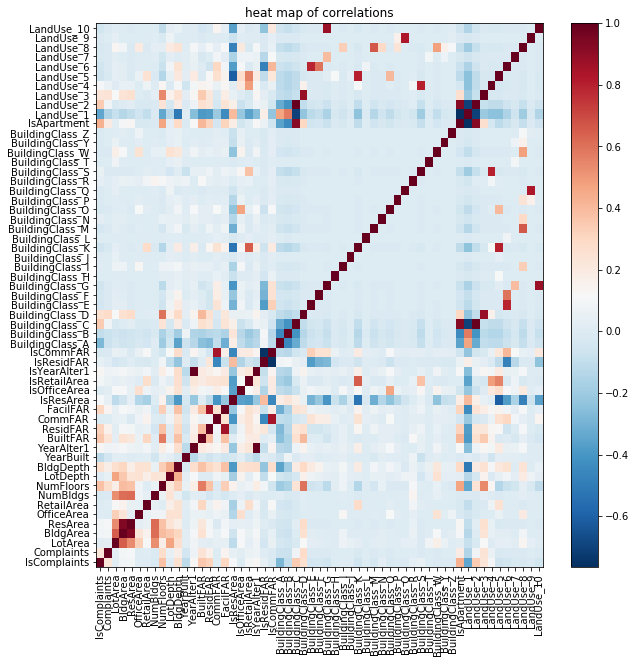

In [48]:
# Correlation heatmap
AllForHeat = df.corr().transpose()
fig, ax = plt.subplots(figsize=(10,10))
im = ax.pcolor(AllForHeat, cmap='RdBu_r')
row_labels = df.columns; col_labels = df.columns
ax.set_xticklabels(row_labels, minor = False);ax.set_yticklabels(col_labels, minor = False)
#move ticks and labels to the center.
ax.set_xticks(np.arange(AllForHeat.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(AllForHeat.shape[0]) + 0.5, minor=False)
ax.set_title("heat map of correlations")
plt.xticks(rotation=90)
plt.colorbar(im)
plt.show()

<p style="color:Red;">Looking along the bottom 2 rows or leftmost 2 columns, there appear to be some correlations with complaints, though none super strong.  Try visualizing in a different way.</p>

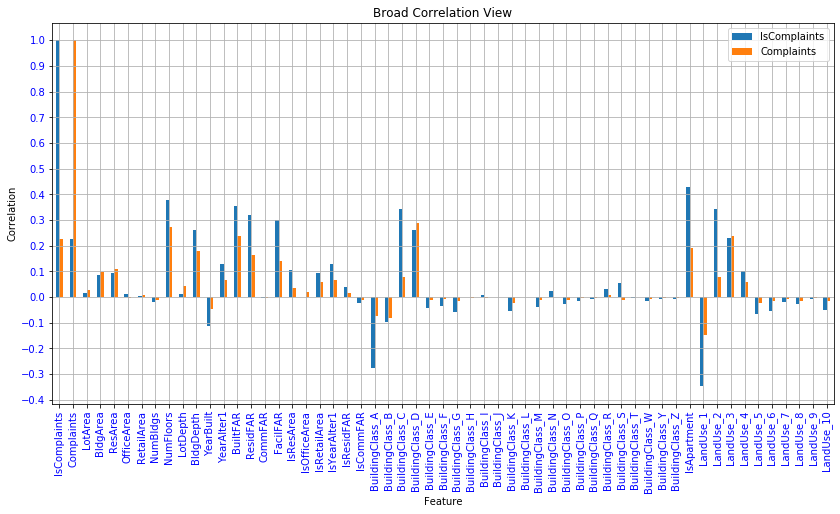

In [49]:
# Bar graph of all correlations
correlations = AllForHeat[['IsComplaints','Complaints']].plot(title="Broad Correlation View",kind='bar',grid=True,figsize=(14,7))
row_labels = df.columns
plt.xticks(np.arange(0,AllForHeat.shape[0],1),labels=row_labels,rotation=90,color='blue')
plt.yticks(np.arange(-0.4,1.1,0.1),color='blue')
plt.ylabel("Correlation")
plt.xlabel("Feature")
plt.show()

<p style="color:Red;">Also look at a sorted list of the actual numbers.</p>

In [50]:
#Sorted list of the strongest correlations.
correlations = AllForHeat[['IsComplaints','Complaints']].abs()
correlations.loc[:,'highest'] = correlations.max(axis=1)
correlations['IsComplaints'] = AllForHeat['IsComplaints']
correlations['Complaints'] = AllForHeat['Complaints']
correlations = correlations[correlations['highest'].ge(0.05)]
correlations.sort_values(by='highest', axis=0, ascending=False, inplace=True)
correlations.drop(['highest'], axis=1, inplace=True)
print("Correlations in descending strength")
correlations

Correlations in descending strength


,IsComplaints,Complaints
IsComplaints,1.000000,0.224490
Complaints,0.224490,1.000000
IsApartment,0.430642,0.190000
NumFloors,0.376281,0.272476
BuiltFAR,0.356718,0.236174
LandUse_1,-0.347156,-0.147378
LandUse_2,0.342127,0.079502
BuildingClass_C,0.341964,0.079674
ResidFAR,0.319841,0.163121
FacilFAR,0.300977,0.140097


In [51]:
# Get the pearson correlations and confidence measures for individual features.
for col in df.columns:
    pearson_coef1, p_value1 = stats.pearsonr(df[col], df['IsComplaints'])
    pearson_coef2, p_value2 = stats.pearsonr(df[col], df['Complaints'])
    threshold = 0.05
    if (abs(pearson_coef1) > threshold and p_value1 < 0.10) or (abs(pearson_coef2) > threshold and p_value2 < 0.10):
        print("%-20s % 1.3f (%1.4f) % 1.3f (%1.4f)" % (col, pearson_coef1, p_value1, pearson_coef2, p_value2))

IsComplaints          1.000 (0.0000)  0.224 (0.0000)
Complaints            0.224 (0.0000)  1.000 (0.0000)
BldgArea              0.087 (0.0000)  0.097 (0.0000)
ResArea               0.094 (0.0000)  0.108 (0.0000)
NumFloors             0.376 (0.0000)  0.272 (0.0000)
BldgDepth             0.261 (0.0000)  0.179 (0.0000)
YearBuilt            -0.113 (0.0000) -0.045 (0.0000)
YearAlter1            0.128 (0.0000)  0.068 (0.0000)
BuiltFAR              0.357 (0.0000)  0.236 (0.0000)
ResidFAR              0.320 (0.0000)  0.163 (0.0000)
FacilFAR              0.301 (0.0000)  0.140 (0.0000)
IsResArea             0.105 (0.0000)  0.036 (0.0000)
IsRetailArea          0.092 (0.0000)  0.059 (0.0000)
IsYearAlter1          0.128 (0.0000)  0.068 (0.0000)
BuildingClass_A      -0.275 (0.0000) -0.073 (0.0000)
BuildingClass_B      -0.096 (0.0000) -0.081 (0.0000)
BuildingClass_C       0.342 (0.0000)  0.080 (0.0000)
BuildingClass_D       0.261 (0.0000)  0.287 (0.0000)
BuildingClass_G      -0.056 (0.0000) -0.015 (0

In [52]:
#check a few of these to see if they are different data points that capture the same relationship.
def see_pearson(a,b):
    pearson_coef, p_value = stats.pearsonr(df[a], df[b])
    print("%-20s %-20s % 1.3f (%1.4f)" % (a, b, pearson_coef, p_value))
see_pearson('ResidFAR','FacilFAR')
see_pearson('ResidFAR','BuiltFAR')
see_pearson('FacilFAR','BuiltFAR')
see_pearson('BuildingClass_A','LandUse_1') #Single family
see_pearson('BuildingClass_C','LandUse_2') #Walk up apartments
see_pearson('BuildingClass_D','LandUse_3') #Elevator apartments
see_pearson('NumFloors','BuiltFAR') #Taller buildings have more floor area?
see_pearson('BldgDepth','BuiltFAR') #Deeper buildings have more floor area?
see_pearson('NumFloors','BldgDepth') #Taller vs Deeper?

ResidFAR             FacilFAR              0.857 (0.0000)
ResidFAR             BuiltFAR              0.385 (0.0000)
FacilFAR             BuiltFAR              0.374 (0.0000)
BuildingClass_A      LandUse_1             0.466 (0.0000)
BuildingClass_C      LandUse_2             0.998 (0.0000)
BuildingClass_D      LandUse_3             0.889 (0.0000)
NumFloors            BuiltFAR              0.577 (0.0000)
BldgDepth            BuiltFAR              0.379 (0.0000)
NumFloors            BldgDepth             0.337 (0.0000)


<p style="color:Red;">ResidFAR and FacilFAR are strongly correlated to each other.  The documentation says FAR is the "Floor Area Ratio" between the building and the LOT.  Residential and "Community Facility" seem to always be very similar to each other.  There is separate data for building category and land use category.  Similarly there is a strong correspondence between these two values.  The correlations drawn from some of these are essentially saying the same thing.  Furthermore, the ResidFAR and FacilFAR are indications of the "maximum allowable" floor area ratios.  The BuiltFAR is the ratio of the ACTUAL floor area to the lot area.</p>
<p style="color:Red;"><b>Conclusion:  </b>It Only makes sense to use one of two values that express the same information.  It doesn't make sense to concern ourselves with "maximum allowable" in cases where we also have "actual".</p>

#### Visualize strongest Pearson correlations

In [53]:
# Limit only to most relevant features.
features_of_interest = ['NumFloors','BuiltFAR','BldgDepth',
                        'LandUse_1', 'BuildingClass_A','BuildingClass_B',
                        'IsApartment', 'LandUse_2','BuildingClass_C',
                        'LandUse_3','BuildingClass_D',
                        'YearBuilt']
# Interpret feature names.
friendly_names = {"LandUse_1":"LU1 One and Two Family",
                  "LandUse_2":"LU2 Walk Up Apartments",
                  "LandUse_3":"LU3 Elevator Apartments",
                  'BuiltFAR':'Floor Area Ratio',
                  "IsComplaints":"Any Complaints?",
                  "Complaints":"Complaints per Address",
                  'BuildingClass_A':'BA One Family','BuildingClass_B':'BB Two Family','BuildingClass_C':'BC Walk Up Apartments','BuildingClass_D':'BD Elevator Apartments'}

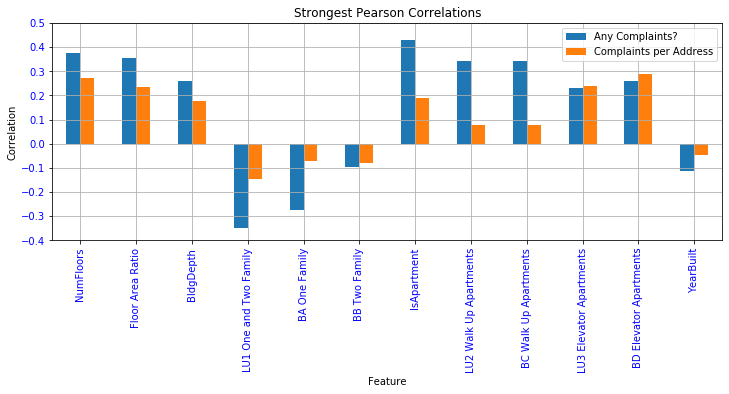

In [54]:
strongest = correlations.copy(deep=True)
strongest = strongest.loc[features_of_interest]
strongest.rename(mapper=friendly_names, axis=1, inplace=True)
strongest.rename(mapper=friendly_names, axis=0, inplace=True)
strongest.plot(title="Strongest Pearson Correlations",kind='bar',grid=True,figsize=(12,4))
labels = strongest.index
plt.ylabel("Correlation")
plt.xlabel("Feature")
plt.xticks(np.arange(0,strongest.shape[0],1),labels=labels, rotation=90,color='blue')
plt.yticks(np.arange(-0.4,0.6,0.1),color='blue')
plt.show()

### Alternative approaches

<p style="color:Red;">A few attempts to build a model to see whether the correlations seen with Pearson Correlation above seem correct.</p>

#### Multiple Linear Regression

In [55]:
lm=LinearRegression()
Z = df[features_of_interest]
lm.fit(Z, df['Complaints'])
Yhat=lm.predict(Z)
print("---Equation of the model")
print("Number of Complaints =")
print("% 10.10f" % (lm.intercept_))
for i in range(len(features_of_interest)):
    print(" + % 10.10f * %s" % (lm.coef_[i], features_of_interest[i]))
print ("")
print ("---Scores")
#print ("%-20s % 10.10f % 10.10f % 10.10f" % ("Complaints min/mean/max", df['Complaints'].min(), df['Complaints'].mean(), df['Complaints'].max()))
print ("%-20s % 10.10f" % ("RMSE", sqrt(mean_squared_error(df['Complaints'],Yhat))))
print ("%-20s % 10.10f" % ("R Squared", lm.score(Z,df['Complaints'])))

---Equation of the model
Number of Complaints =
-1.6669086259
 +  4.7918540034 * NumFloors
 +  4.3043623441 * BuiltFAR
 +  4.2084829289 * BldgDepth
 +  15.7780039432 * LandUse_1
 + -8.4851793432 * BuildingClass_A
 + -10.0030669334 * BuildingClass_B
 +  4743386985398.2021484375 * IsApartment
 +  2.0688907506 * LandUse_2
 + -4743386985388.7949218750 * BuildingClass_C
 + -26.1174908985 * LandUse_3
 + -4743386985308.1503906250 * BuildingClass_D
 + -2.8242314581 * YearBuilt

---Scores
RMSE                  54.1936191033
R Squared             0.1147956475


<p style="color:Red;">The linear model does not fit the data well.  But then again, the Pearson correlation values were showing as weak correlations.  The coefficients appear to agree roughly with the Pearson correlations with apartment coefficients dominating the others.</p>

#### Polynomial Regression
The scaling normally done with this approach was done earlier.

In [56]:
pr=PolynomialFeatures(degree=4,include_bias=False)
lm=LinearRegression()
Z = pr.fit_transform(df[features_of_interest])

lm.fit(Z, df['Complaints'])
Yhat=lm.predict(Z)
print("---Equation of the model")
print("Number of Complaints =")
print("% 10.10f" % (lm.intercept_))
for i in range(len(features_of_interest)):
    print(" + % 10.10f * %s" % (lm.coef_[i], features_of_interest[i]))
print ("")
print ("---Scores")
print ("%-20s % 10.10f" % ("RMSE", sqrt(mean_squared_error(df['Complaints'],Yhat))))
print ("%-20s % 10.10f" % ("R Squared", lm.score(Z,df['Complaints'])))

---Equation of the model
Number of Complaints =
 1.9249135660
 +  0.6088916935 * NumFloors
 +  2.0646877859 * BuiltFAR
 + -1.3358737862 * BldgDepth
 + -0.3382602591 * LandUse_1
 + -0.0345365636 * BuildingClass_A
 +  0.0552246732 * BuildingClass_B
 +  22.3004097134 * IsApartment
 + -7.0994164260 * LandUse_2
 + -2.3017184153 * BuildingClass_C
 + -73.5473532750 * LandUse_3
 +  24.6021261379 * BuildingClass_D
 + -2.0318522742 * YearBuilt

---Scores
RMSE                  52.4599226658
R Squared             0.1705264851


<p style="color:Red;">This model predicts the data better than linear regression, but still only weakly.  I do notice however that the interplay between the coefficients agree with the Pearson correlations, but in more nuanced ways.  For example, the two family homes (B) coefficient actually comes out slighly positive, but it is merely tuning itself within the broader land use (1) coefficient relative to single family homes (A).</p>

<a id="conclusion"></a>
# Concluding Remarks
---

In this exercise, you will use a feature-engineered dataset to determine whether a predictive model can be built to predict the complaint (of the Complaint Type that you decided to focus on in Week 2) by using past data.

Using the best model, you need to predict the number of future complaints (of the Complaint Type that you decided to focus on in Question 1).

<b><u>Yes</u>, the HEATING/HOT WATER complaints (question 1) reported in the BRONX borough (question 2) have an obvious relationship with the housing characteristics.</b>  Some weak but distinct correlations:
<ul>
    <li><b><u>Building Type</u></b>.  Certain types are more or less prone to heating complaints than others:
    <ul>
        <li>Apartments!  <i>(Correlation:  0.43)</i>
        <ul>
            <li>Walk up apartments.  These are the most likely to have complaints.   <i>(Correlation:  0.34)</i>
            <li>Elevator apartments.  These are the second most likely to have complaints. <i>(Correlation:  0.26)</i>
        </ul>
        <li>One and two family homes.  These are <u>less</u> likely to have heating complaints than other building types.  <i>(Correlation:  -0.34 <u>negative</u>)</i>
    </ul>
    <li><b><u>Size</u></b>.  The larger the building, the more heating complaints.
    <ul>
        <li>Number of Floors.  <i>(Correlation:  0.27~0.37)</i>
        <li>Floor Area.  <i>(Correlation:  0.23~0.35)</i>
        <li>Building Depth.  <i>(Correlation:  0.17~0.26)</i>
    </ul>
</ul>
<u><b>Additional insights</b></u>:
<ul>
    <li>When there are complaints at elevator apartments it is much more likely there will be a <u>large number of complaints per address</u> with <i>0.28 correlation</i> compared to <i>only 0.07</i> for the walk up apartments.
    <li>The land use category 1 encompasses both single and two family homes.  Breaking them down by building class A and B, shows that single family homes contribute much more to the negative correlation to complaints <i>(-0.27)</i> than two family homes. <i>(-0.09)</i>
</ul>